## Importing Libraries

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
from tqdm import tqdm
import soundfile as sf
from torchinfo import summary
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Data Preparation

In [2]:
# Load the clean audio
audio_file_path = "original_music_audio.mp3"
clean_audio, sr = librosa.load(audio_file_path, sr=None)
print(f"Audio Loaded: {len(clean_audio)} samples, Sample rate: {sr}")

Audio Loaded: 4872960 samples, Sample rate: 44100


In [3]:
clean_audio.max()

np.float32(1.0144527)

In [4]:
clean_audio.min()

np.float32(-1.0022012)

In [5]:
# Function to add noise
def add_noise(audio, noise_level=0.05):
    noise = np.random.normal(0, noise_level, audio.shape)
    return audio + noise

# Add noise to the audio
noisy_audio = add_noise(clean_audio)

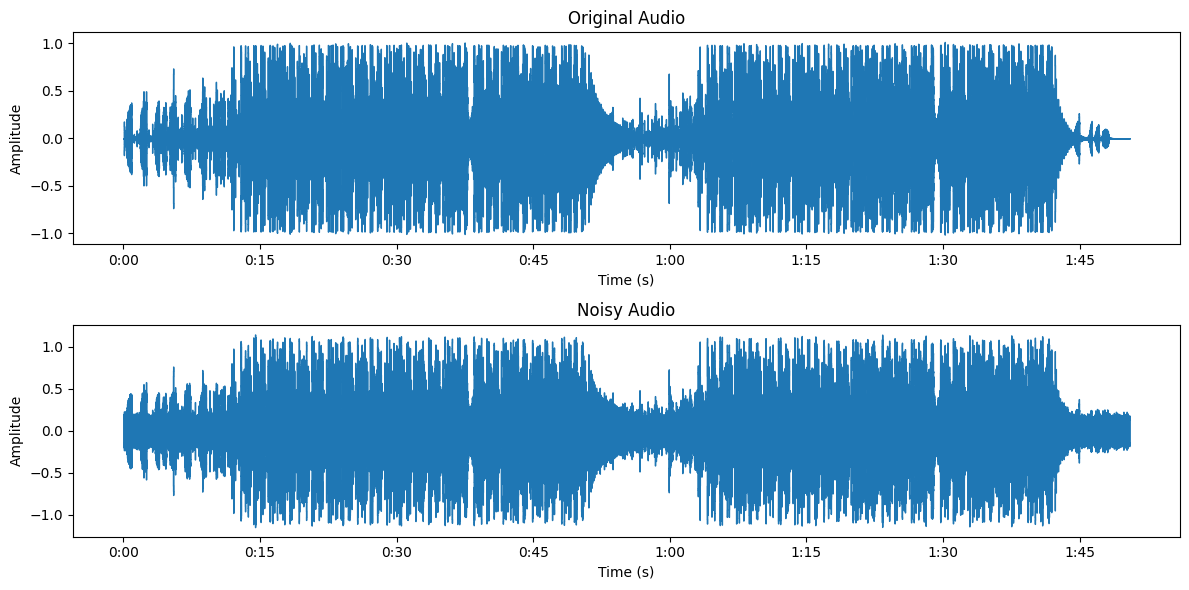

In [6]:
# Plot original and noisy audio
plt.figure(figsize=(12, 6))

# Plot original audio
plt.subplot(2, 1, 1)
librosa.display.waveshow(clean_audio, sr=sr)
plt.title("Original Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Plot noisy audio
plt.subplot(2, 1, 2)
librosa.display.waveshow(noisy_audio, sr=sr)
plt.title("Noisy Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [7]:
# Save the noisy audio to a WAV file
noisy_audio_path = "noisy_music_audio.wav"
sf.write(noisy_audio_path, noisy_audio, sr)
print(f"Noisy audio saved to: {noisy_audio_path}")

Noisy audio saved to: noisy_music_audio.wav


In [8]:
# 1-second chunks (44100 sample in each example)
chunk_size = sr  

# Split audio into chunks
chunks_clean = [clean_audio[i:i+chunk_size] for i in range(0, len(clean_audio), chunk_size)]
chunks_noisy = [noisy_audio[i:i+chunk_size] for i in range(0, len(noisy_audio), chunk_size)]

# Convert chunks to PyTorch tensors
def chunks_to_tensor(chunks):
    return torch.tensor([librosa.util.fix_length(chunk, size=chunk_size) for chunk in chunks])

X = chunks_to_tensor(chunks_noisy)
Y = chunks_to_tensor(chunks_clean)

C:\Users\rayyan.shabbir\AppData\Local\Temp\ipykernel_43404\2845325584.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor([librosa.util.fix_length(chunk, size=chunk_size) for chunk in chunks])


In [9]:
print(X)

tensor([[ 0.0248, -0.0069,  0.0324,  ...,  0.0232, -0.0279,  0.0235],
        [-0.0522, -0.0309,  0.0072,  ..., -0.0817, -0.0063,  0.0613],
        [ 0.0458,  0.0371,  0.0615,  ...,  0.0021, -0.0333,  0.0229],
        ...,
        [ 0.0201,  0.0739, -0.0672,  ..., -0.0153,  0.1136, -0.0068],
        [ 0.1062,  0.0062, -0.0181,  ..., -0.0012,  0.0685, -0.0517],
        [-0.0215,  0.0640, -0.0499,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)


In [10]:
print(Y)

tensor([[ 0.0000e+00, -2.0357e-17, -7.4755e-18,  ..., -1.0647e-02,
         -1.1344e-02, -1.1634e-02],
        [-1.1858e-02, -1.2315e-02, -1.3180e-02,  ...,  1.6292e-02,
          2.6717e-02,  3.7338e-02],
        [ 4.8116e-02,  5.8983e-02,  6.9888e-02,  ...,  2.9645e-03,
          2.8241e-03,  2.6985e-03],
        ...,
        [ 9.6612e-03,  1.1872e-02,  1.3664e-02,  ...,  9.9017e-05,
          1.0770e-04,  1.1139e-04],
        [ 1.1007e-04,  1.0468e-04,  9.6676e-05,  ...,  2.9753e-05,
          1.6603e-05,  1.2649e-05],
        [ 2.1592e-05,  3.5688e-05,  4.2759e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


In [11]:
class AudioDataset(Dataset):
    def __init__(self, noisy_data, clean_data):
        self.noisy_data = noisy_data
        self.clean_data = clean_data

    def __getitem__(self, index):
        noisy = self.noisy_data[index].clone().detach().float()
        clean = self.clean_data[index].clone().detach().float()
        noisy = noisy.unsqueeze(0)
        clean = clean.unsqueeze(0)
        return noisy, clean

    def __len__(self):
        return len(self.noisy_data)


dataset = AudioDataset(X, Y)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Dataset split: {train_size} training samples, {val_size} validation samples")

Dataset split: 88 training samples, 23 validation samples


## Model Architecture

In [12]:
# ConvBlock for 1D audio data with padding to preserve input size
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            # Padding=1 to preserve size
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# EncoderBlock for 1D data
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        features = self.conv_block(x)
        pooled = self.pool(features)
        return features, pooled

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose1d(in_channels, out_channels, kernel_size=2, stride=2, output_padding=1)
        self.conv_block = ConvBlock(out_channels + skip_channels, out_channels)

    def forward(self, x, skip_features):
        x = self.upconv(x)
        
        # Ensure the spatial dimensions match
        if x.size(-1) != skip_features.size(-1):
            diff = skip_features.size(-1) - x.size(-1)
            # Add padding to match dimensions
            x = nn.functional.pad(x, (0, diff))  
        
        # Concatenate along the channel dimension
        x = torch.cat([x, skip_features], dim=1)  
        x = self.conv_block(x)
        return x


# UNet model for 1D audio data
class UNetAudio(nn.Module):
    def __init__(self, input_channels=1, num_classes=1):
        super(UNetAudio, self).__init__()

        # Encoder Blocks
        self.encoder1 = EncoderBlock(input_channels, 16)
        self.encoder2 = EncoderBlock(16, 32)
        self.encoder3 = EncoderBlock(32, 64)
        self.encoder4 = EncoderBlock(64, 128)

        # Bottleneck
        self.bottleneck = ConvBlock(128, 256)

        # Decoder Blocks
        self.decoder1 = DecoderBlock(256, 128, 128)
        self.decoder2 = DecoderBlock(128, 64, 64)
        self.decoder3 = DecoderBlock(64, 32, 32)
        self.decoder4 = DecoderBlock(32, 16, 16)

        # Final convolution layer (Outputs the same size as input)
        self.final_conv = nn.Conv1d(16, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        s1, p1 = self.encoder1(x)
        s2, p2 = self.encoder2(p1)
        s3, p3 = self.encoder3(p2)
        s4, p4 = self.encoder4(p3)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with skip connections
        d1 = self.decoder1(b, s4)
        d2 = self.decoder2(d1, s3)
        d3 = self.decoder3(d2, s2)
        d4 = self.decoder4(d3, s1)

        # Final outputx
        outputs = self.final_conv(d4)
        return outputs


# Initialize the model (Mono audio input, single output channel)
model = UNetAudio(input_channels=1, num_classes=1)
# Get the model summary
summary(model)

Layer (type:depth-idx)                   Param #
UNetAudio                                --
├─EncoderBlock: 1-1                      --
│    └─ConvBlock: 2-1                    --
│    │    └─Sequential: 3-1              912
│    └─MaxPool1d: 2-2                    --
├─EncoderBlock: 1-2                      --
│    └─ConvBlock: 2-3                    --
│    │    └─Sequential: 3-2              4,800
│    └─MaxPool1d: 2-4                    --
├─EncoderBlock: 1-3                      --
│    └─ConvBlock: 2-5                    --
│    │    └─Sequential: 3-3              18,816
│    └─MaxPool1d: 2-6                    --
├─EncoderBlock: 1-4                      --
│    └─ConvBlock: 2-7                    --
│    │    └─Sequential: 3-4              74,496
│    └─MaxPool1d: 2-8                    --
├─ConvBlock: 1-5                         --
│    └─Sequential: 2-9                   --
│    │    └─Conv1d: 3-5                  98,560
│    │    └─BatchNorm1d: 3-6             512
│    │    

## Training & Validation (Single Iteration)

In [13]:
# Define SNR loss
class SNRLoss(nn.Module):
    def __init__(self):
        super(SNRLoss, self).__init__()

    def forward(self, pred, target):
        # Ensure same shape
        pred = pred.view(target.shape)
        noise = target - pred
        signal_power = torch.mean(target ** 2, dim=-1)
        noise_power = torch.mean(noise ** 2, dim=-1)
        snr = 10 * torch.log10(signal_power / noise_power + 1e-8)
        # Negative because we want to maximize SNR
        return -torch.mean(snr)  

In [14]:
# Training function
def train(model, train_loader, val_loader, optimizer, num_epochs=20, device="cuda", criterion=None):
    # If no loss function is provided, use Mean Squared Error Loss by default
    if criterion is None:
        criterion = torch.nn.MSELoss()

    model.to(device)
    criterion.to(device)
    
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        train_loss = 0
        for noisy, clean in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
            noisy, clean = noisy.to(device), clean.to(device)
            
            # Forward pass
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for noisy, clean in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
                noisy, clean = noisy.to(device), clean.to(device)

                # Forward pass
                outputs = model(noisy)
                loss = criterion(outputs, clean)

                # Backward pass
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

# Initialize model, optimizer, and data loaders
model = UNetAudio(input_channels=1, num_classes=1)

# Ensure data tensors are shaped as [batch_size, channels, sequence_length]
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define optimizer
optimizer = optim.NAdam(model.parameters(), lr=0.01)

# Train the model
train_losses, val_losses = train(model, train_loader, val_loader, optimizer, num_epochs=20, device="cuda" if torch.cuda.is_available() else "cpu", criterion=SNRLoss())

Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Epoch 1/20 | Train Loss: 0.4924 | Val Loss: 4.5857


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Epoch 2/20 | Train Loss: -4.8128 | Val Loss: 0.9421


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Epoch 3/20 | Train Loss: -7.2610 | Val Loss: 0.4221


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 4/20 | Train Loss: -9.2063 | Val Loss: -4.5064


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Epoch 5/20 | Train Loss: -9.2755 | Val Loss: -5.8356


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Epoch 6/20 | Train Loss: -10.3736 | Val Loss: -6.1180


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Epoch 7/20 | Train Loss: -11.2768 | Val Loss: -12.3718


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 8/20 | Train Loss: -11.0151 | Val Loss: -9.2680


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Epoch 9/20 | Train Loss: -12.0085 | Val Loss: -6.9512


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 10/20 | Train Loss: -11.3721 | Val Loss: -10.8448


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Epoch 11/20 | Train Loss: -11.7604 | Val Loss: -8.0108


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 12/20 | Train Loss: -11.6155 | Val Loss: -10.0552


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Epoch 13/20 | Train Loss: -12.3271 | Val Loss: -13.6853


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Epoch 14/20 | Train Loss: -11.7072 | Val Loss: -12.7045


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Epoch 15/20 | Train Loss: -12.2138 | Val Loss: -11.7107


Epoch 16/20 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Epoch 16/20 | Train Loss: -12.2087 | Val Loss: -11.0293


Epoch 17/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Epoch 17/20 | Train Loss: -12.5059 | Val Loss: -8.7920


Epoch 18/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Epoch 18/20 | Train Loss: -12.8199 | Val Loss: -10.5589


Epoch 19/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 19/20 | Train Loss: -13.0666 | Val Loss: -14.4700


Epoch 20/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

Epoch 20/20 | Train Loss: -12.8231 | Val Loss: -13.6659


## Saving Model

In [122]:
# Save the model and optimizer states
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
}, "music_model_checkpoint.pth")

## Prediction / Results (Training data)

In [123]:
def predict_and_save(model, data_loader, output_path, device="cuda"):
    model.eval()
    predicted_audio = []

    with torch.no_grad():
        for noisy, _ in tqdm(data_loader, desc="Predicting on Training Data"):
            noisy = noisy.to(device)
            # Perform prediction
            outputs = model(noisy)
            predicted_audio.append(outputs.cpu())

    # Pad the predictions so they all have the same length
    predicted_audio_padded = pad_sequence(predicted_audio, batch_first=True, padding_value=0)

    # Squeeze the tensor to remove extra dimensions
    # Assuming the model output is [batch_size, channels, sequence_length], we need to handle it
    # Removing channel dimension.
    predicted_audio = predicted_audio_padded.squeeze(1)

    # Check if the tensor is still more than 2D, flatten it if necessary
    if predicted_audio.dim() > 2:
        predicted_audio = predicted_audio.view(-1)

    # Convert tensor to numpy array
    predicted_audio = predicted_audio.numpy()
    
    # Save the combined result as a .wav file
    torchaudio.save(output_path, torch.tensor(predicted_audio).unsqueeze(0), 44100)  # Assuming 44100 Hz sample rate
    print(f"Prediction saved to {output_path}")


output_path = "predicted_music_audio.wav"
predict_and_save(model, train_loader, output_path, device="cuda" if torch.cuda.is_available() else "cpu")


Predicting on Training Data: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]

Prediction saved to predicted_music_audio.wav


In [124]:
# Load the predicted audio
audio_file_path = "predicted_music_audio.wav"
predicted_audio, sr = librosa.load(audio_file_path, sr=None)
print(f"Audio Loaded: {len(predicted_audio)} samples, Sample rate: {sr}")

Audio Loaded: 4233600 samples, Sample rate: 44100


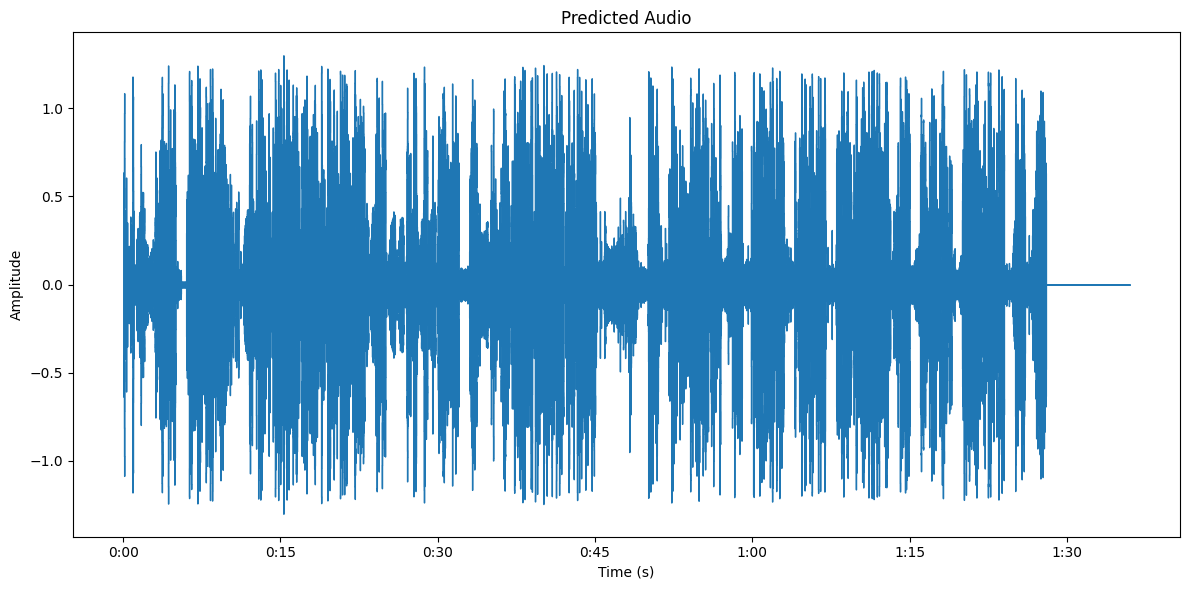

In [125]:
# Plot original and noisy audio
plt.figure(figsize=(12, 6))

# Plot original audio
plt.subplot(1, 1, 1)
librosa.display.waveshow(predicted_audio, sr=sr)
plt.title("Predicted Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

## Feeding Output back into Input (Model) for 5 times.

In [126]:
def predict_and_save_5_iter(model, data_loader, output_path, device="cuda", num_iterations=5, loss_fn=None):
    model.eval()

    # If no loss function is provided, use Mean Squared Error Loss by default
    if loss_fn is None:
        loss_fn = torch.nn.MSELoss()

    # Initial prediction with the data_loader
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")

        # Run the prediction loop
        predicted_audio = []
        total_loss = 0.0
        num_batches = 0

        with torch.no_grad():
            for noisy, clean in tqdm(data_loader, desc="Predicting on Data"):
                noisy = noisy.to(device)
                clean = clean.to(device)
                
                # Perform prediction
                outputs = model(noisy)

                # Calculate the loss (error) between the predicted and actual clean audio
                loss = loss_fn(outputs, clean)
                # Accumulate loss
                total_loss += loss.item()  

                predicted_audio.append(outputs.cpu())  # Store the predicted output

                num_batches += 1

        # Calculate the average loss
        avg_loss = total_loss / num_batches
        # print(f"Average Loss (MSE) for Iteration {iteration + 1}: {avg_loss}")

        # Pad the predictions so they all have the same length
        predicted_audio_padded = pad_sequence(predicted_audio, batch_first=True, padding_value=0)

        # Squeeze the tensor to remove extra dimensions
        predicted_audio = predicted_audio_padded.squeeze(1)  # Remove the channel dimension

        # Flatten if necessary
        if predicted_audio.dim() > 2:
            predicted_audio = predicted_audio.view(-1)

        # Convert tensor to numpy array
        predicted_audio = predicted_audio.numpy()

        # Save the combined result as a .wav file (overwrite the file each time)
        torchaudio.save(output_path, torch.tensor(predicted_audio).unsqueeze(0), 44100)  # Assuming 44100 Hz sample rate
        print(f"Prediction saved to {output_path}")

        # Load the saved audio file to pass it again to the model
        waveform, sample_rate = torchaudio.load(output_path)
        print(f"Loaded audio with shape {waveform.shape} and sample rate {sample_rate}")


output_path = "predicted_music_audio_iter.wav"
snr_loss_fn = SNRLoss()
predict_and_save_5_iter(model, train_loader, output_path, device="cuda" if torch.cuda.is_available() else "cpu", num_iterations=5, loss_fn=snr_loss_fn)


Iteration 1/5


Predicting on Data: 100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


Prediction saved to predicted_music_audio_iter.wav
Loaded audio with shape torch.Size([1, 4233600]) and sample rate 44100
Iteration 2/5


Predicting on Data: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Prediction saved to predicted_music_audio_iter.wav
Loaded audio with shape torch.Size([1, 4233600]) and sample rate 44100
Iteration 3/5


Predicting on Data: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Prediction saved to predicted_music_audio_iter.wav
Loaded audio with shape torch.Size([1, 4233600]) and sample rate 44100
Iteration 4/5


Predicting on Data: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


Prediction saved to predicted_music_audio_iter.wav
Loaded audio with shape torch.Size([1, 4233600]) and sample rate 44100
Iteration 5/5


Predicting on Data: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]

Prediction saved to predicted_music_audio_iter.wav
Loaded audio with shape torch.Size([1, 4233600]) and sample rate 44100
